## Redes Neuronales Convolucionales (Análisis)

En este laboratorio, realizaremos un análisis para determinar si el reescalado de imágenes y su conversión a escala de grises tienen un impacto significativo en la precisión del modelo.

In [1]:
# importamos las librerias que vamos a utilizar en el notebook

import torch # libreria principal
import torch.nn as nn # libreria para redes neuronales
import torch.optim as optim # libreria para optimizacion
from torch.utils.data import DataLoader, Dataset # libreria para cargar los datos
import torchvision.transforms as transforms # libreria para transformar los datos
from torchvision import models # libreria para modelos pre-entrenados
from datasets import load_dataset # libreria para cargar los datos
from tqdm import tqdm # libreria para barra de progreso

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

Trabajaremos con una versión reducida del conjunto de datos ImageNet conocida como Tiny ImageNet. Esta variante incluye un conjunto de entrenamiento compuesto por 100,000 ejemplos y un conjunto de prueba de 10,000 ejemplos.

In [2]:
# cargamos el dataset de Tiny ImageNet y lo guardamos en la variable dataset
dataset_ti = load_dataset("zh-plus/tiny-imagenet")
dataset_ti

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Optaremos por utilizar solamente 15 clases en lugar de las 200 disponibles en el conjunto de datos debido a la restricción de contar con solo 500 ejemplos por categoría. Con esta limitación en la cantidad de datos, el aumento de datos se vuelve desafiante, y requeriría recursos de hardware significativos para abordar el entrenamiento en un conjunto de datos tan grande. Al reducir el número de clases, estamos simplificando la tarea y mejorando la viabilidad del entrenamiento, lo que debería conducir a un resultado más efectivo en términos de precisión del modelo.

In [3]:
# Define las etiquetas deseadas
etiquetas_deseadas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Filtra el conjunto de entrenamiento y validación para mantener solo las etiquetas deseadas
dataset_ti['train'] = dataset_ti['train'].filter(lambda example: example['label'] in etiquetas_deseadas) # type: ignore
dataset_ti['valid'] = dataset_ti['valid'].filter(lambda example: example['label'] in etiquetas_deseadas) # type: ignore

# Actualiza el número de etiquetas en el conjunto de entrenamiento y validación
dataset_ti['train'].set_format(type=dataset_ti['train'].format["type"], columns=['image', 'label']) # type: ignore
dataset_ti['valid'].set_format(type=dataset_ti['valid'].format["type"], columns=['image', 'label']) # type: ignore
dataset_ti

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7500
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
})

### Función para graficar

Esta función se utiliza para visualizar imágenes aleatorias con el fin de tener una idea de los tipos de datos con los que estamos trabajando.

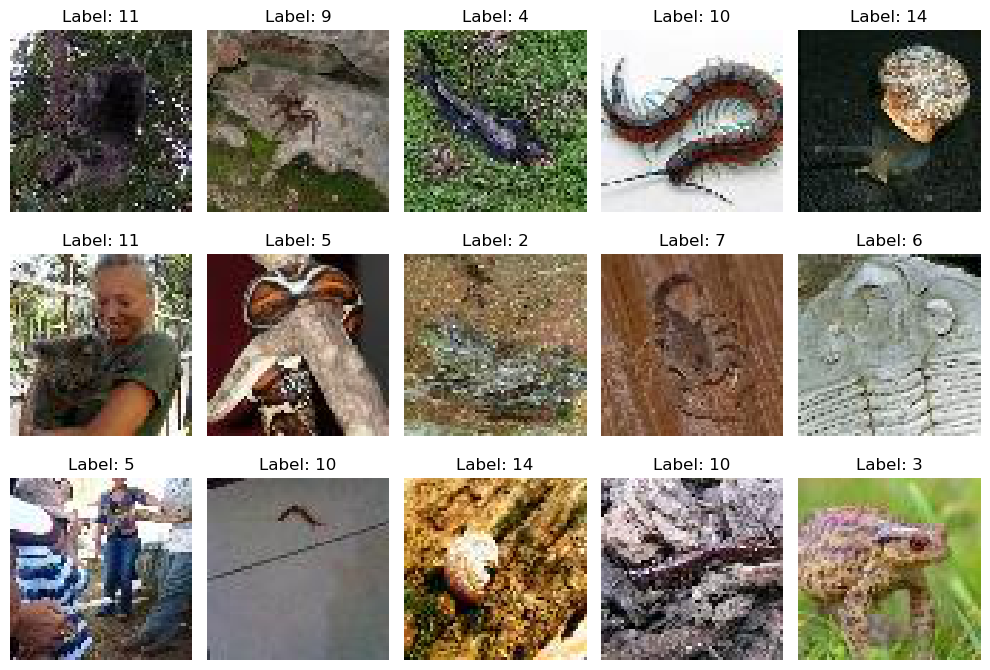

In [4]:
# graficamos algunas imagenes para saber con que tipo de datos estamos trabajando
import matplotlib.pyplot as plt
import random

def show_random_images(dataset, num_rows, num_columns):
    # Crear una figura y ejes para la tabla de imágenes
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 7))

    for i in range(num_rows):
        for j in range(num_columns): 
            # Elegir aleatoriamente una imagen del conjunto de entrenamiento
            random_index = random.randint(0, len(dataset['train']) - 1) 
            random_image = dataset['train'][random_index]['image'] 
            random_label = dataset['train'][random_index]['label'] 

            # Mostrar la imagen en el subgráfico correspondiente
            axes[i, j].imshow(random_image, interpolation='nearest')
            axes[i, j].set_title(f"Label: {random_label}")
            axes[i, j].axis('off')  # Ocultar los ejes

    # Ajustar el espacio entre los subgráficos para que se vean bien
    plt.tight_layout()
    # Mostrar la tabla de imágenes
    plt.show()

# Llamar a la función con tu dataset
show_random_images(dataset_ti, 3, 5)

### Transformaciones 

En esta sección, implementamos algunas transformaciones que deseamos aplicar a las imágenes. En nuestro caso, estas transformaciones incluyen las siguientes:

`trans0: `Imagenes sin transformarlas.

`trans1: `Esta transformación se utiliza para convertir las imágenes a escala de grises, preservando la dimensión original.

`trans2: `Esta transformación se encarga de redimensionar las imágenes a una escala uniforme de 40x40 píxeles, manteniendo la información en formato RGB.

`trans3: `En esta transformación, aplicamos ambas modificaciones a las imágenes: las convertimos a escala de grises y las redimensionamos a una dimensión de 32x32 píxeles.

In [5]:
class EnsureRGBChannels:
    def __call__(self, image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return image

trans0 = transforms.Compose([
    EnsureRGBChannels(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

trans1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

trans2 = transforms.Compose([
    EnsureRGBChannels(),
    transforms.Resize((40, 40)),
    transforms.ToTensor()
])

trans3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

### Dataset Custom

Esta clase facilitará el manejo de nuestro conjunto de datos, simplificando las operaciones y la interacción con él.

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset, split, transform=None, data_augmentation=False, num_transforms=1):
        self.X = dataset[split]['image']  # cargar imágenes
        self.y = dataset[split]['label']  # cargar etiquetas
        self.transform = transform
        self.num_transforms = num_transforms

        # Duplica las imágenes en el conjunto de entrenamiento si data_augmentation es True
        if split == 'train' and data_augmentation:
            self.X *= self.num_transforms 
            self.y *= self.num_transforms

    # Devuelve el número de muestras en el conjunto de datos.
    def __len__(self):
        return len(self.X)

    # Devuelve una muestra del conjunto de datos en la posición index.
    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        # Aplica el transformador a la imagen si está definido
        if self.transform:
            img = self.transform(img)

        return img, label

### Dataset0

El `dataset0` corresponde a un conjunto de datos donde no se ha aplicado ninguna transformación específica.

In [7]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset0 = { # dataset1 es el dataset a escalas de grises y reescalado se mantienen las dimensiones
    'train' : CustomDataset(dataset_ti, 'train', transform=trans0, data_augmentation=True, num_transforms=1),
    'test' : CustomDataset(dataset_ti, 'valid', transform=trans1)
}

len(dataset0['train']), len(dataset0['test'])

(7500, 750)

### Dataset1

El `dataset1` corresponde a un conjunto de datos donde se ha aplicado una transformación específica: las imágenes han sido convertidas a escala de grises, sin embargo, se han mantenido inalteradas en cuanto a sus dimensiones originales, conservando así su resolución y tamaño sin modificaciones en ese aspecto.

In [8]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset1 = { # dataset1 es el dataset a escalas de grises y reescalado se mantienen las dimensiones
    'train' : CustomDataset(dataset_ti, 'train', transform=trans1, data_augmentation=True, num_transforms=1),
    'test' : CustomDataset(dataset_ti, 'valid', transform=trans1)
}

len(dataset1['train']), len(dataset1['test'])

(7500, 750)

In [9]:
# mostrar las dimensiones de una imagen del conjunto de datos de entrenamiento
dataset1['train'][0][0].shape

torch.Size([3, 64, 64])

### Dataset2

El `dataset2` se refiere a un conjunto de datos en el cual las imágenes se han mantenido en formato RGB (a todo color), pero se han redimensionado de manera uniforme a una resolución de 40x40 píxeles. Esto significa que, a diferencia del dataset1, en el que las imágenes fueron convertidas a escala de grises, en el dataset2 se ha conservado la información de color original mientras se ajusta el tamaño de las imágenes a la nueva dimensión.

In [10]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset2 = { # dataset2 es el dataset a escalas RGB pero reescalado es de 40x40
    'train' : CustomDataset(dataset_ti, 'train', transform=trans2, data_augmentation=True, num_transforms=1),
    'test' : CustomDataset(dataset_ti, 'valid', transform=trans2)
}

len(dataset2['train']), len(dataset2['test'])

(7500, 750)

### Dataset3

El `dataset3` se refiere a un conjunto de datos en el cual se aplica las dos transformaciones anteriores, pero con una escala de 32x32.

In [11]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset3 = { # dataset2 es el dataset a escalas RGB pero reescalado es de 40x40
    'train' : CustomDataset(dataset_ti, 'train', transform=trans3, data_augmentation=True, num_transforms=1),
    'test' : CustomDataset(dataset_ti, 'valid', transform=trans3)
}

len(dataset3['train']), len(dataset3['test'])

(7500, 750)

### Dataloader

Hemos creado un DataLoader personalizado para gestionar nuestros datos de manera más eficiente y conveniente. Esto nos permitirá realizar un mejor manejo de los datos al cargarlos y procesarlos de manera adecuada para el entrenamiento de nuestro modelo ResNeXt50 desde cero.

In [12]:
dataloader0 = {
    'train': DataLoader(dataset0['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': DataLoader(dataset0['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader0['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [13]:
dataloader1 = {
    'train': DataLoader(dataset1['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': DataLoader(dataset1['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader1['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [14]:
dataloader2 = {
    'train': DataLoader(dataset2['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': DataLoader(dataset2['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader2['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 40, 40]), torch.Size([64]))

In [15]:
dataloader3 = {
    'train': DataLoader(dataset3['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': DataLoader(dataset3['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader3['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

### Modelo pre entrenado

Vamos a utilizar el modelo ResNeXt50 en este laboratorio. La elección de este modelo se debe a sus capacidades y rendimiento probados en tareas de visión por computadora. ResNeXt50 es conocido por su profundidad y habilidad para aprender representaciones de alta calidad de datos visuales complejos.

Dado que nuestro conjunto de datos ya está normalizado y listo para el entrenamiento, la elección de ResNeXt50 nos brinda una base sólida para abordar nuestra tarea de clasificación de imágenes con confianza.

In [16]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=15, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnext
    resnext = models.resnext50_32x4d(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnext = nn.Sequential(*list(resnext.children())[:-1])
    if freeze:
      for param in self.resnext.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, n_outputs)

  def forward(self, x):
    x = self.resnext(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnext.parameters():
        param.requires_grad=True

In [17]:
# hacemos la prueba de que nuestro modelo funciona correctamente
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 64, 64))
outputs.shape

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 15])

### Entreamiento

Hemos implementado la función `fit` para entrenar nuestro modelo, tal como mencionamos anteriormente. En este caso, estamos realizando un entrenamiento desde cero de nuestra red neuronal basada en el modelo ResNeXt50.

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam([{'params': model.resnext.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch 
                X, y = X.to(device), y.to(device) 
                y_hat = model(X) 
                loss = criterion(y_hat, y) 
                val_loss.append(loss.item()) 
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenamos modelo0

Los ejemplos estan sin ninguna transformación específica.

In [19]:
model0 = ModelCustom(pretrained=True, freeze=True)

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model0, dataloader0, epochs=5, lr_resnet=1e-4, lr_fc=0.001)
model0.unfreeze()
fit(model0, dataloader0, epochs=5, lr_resnet=1e-4, lr_fc=0.001)

val_loss 1.99799 val_acc 0.37242: 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch 1/5 loss 1.69474 val_loss 1.99799 acc 0.49267 val_acc 0.37242


val_loss 2.07927 val_acc 0.35628: 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]


Epoch 2/5 loss 1.26248 val_loss 2.07927 acc 0.60907 val_acc 0.35628


val_loss 2.13420 val_acc 0.36111: 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


Epoch 3/5 loss 1.17484 val_loss 2.13420 acc 0.63144 val_acc 0.36111


val_loss 2.12714 val_acc 0.37050: 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


Epoch 4/5 loss 1.11208 val_loss 2.12714 acc 0.64349 val_acc 0.37050


val_loss 2.21586 val_acc 0.35890: 100%|██████████| 3/3 [00:00<00:00,  7.91it/s]


Epoch 5/5 loss 1.06154 val_loss 2.21586 acc 0.66031 val_acc 0.35890


val_loss 1.97158 val_acc 0.46374: 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]


Epoch 1/5 loss 0.91168 val_loss 1.97158 acc 0.71879 val_acc 0.46374


val_loss 2.02288 val_acc 0.48406: 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


Epoch 2/5 loss 0.21250 val_loss 2.02288 acc 0.93172 val_acc 0.48406


val_loss 2.31287 val_acc 0.50509: 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]


Epoch 3/5 loss 0.06992 val_loss 2.31287 acc 0.98098 val_acc 0.50509


val_loss 2.41215 val_acc 0.48357: 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]


Epoch 4/5 loss 0.06811 val_loss 2.41215 acc 0.98226 val_acc 0.48357


val_loss 2.68572 val_acc 0.51268: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]

Epoch 5/5 loss 0.07700 val_loss 2.68572 acc 0.97440 val_acc 0.51268


### Entrenamos modelo1

Los ejemplos estan en escala de grises

In [21]:
# Entrenando con finetuning (Congelando y Descongelando), entrenamos solo la capa de salida (fc) y luego todas las capas
model1 = ModelCustom(pretrained=True, freeze=True)

In [22]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model1, dataloader1, epochs=5, lr_resnet=1e-4, lr_fc=0.001)
model1.unfreeze()
fit(model1, dataloader1, epochs=5, lr_resnet=1e-4, lr_fc=0.001)

val_loss 1.91491 val_acc 0.40996: 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]


Epoch 1/5 loss 2.15300 val_loss 1.91491 acc 0.32278 val_acc 0.40996


val_loss 1.89876 val_acc 0.42801: 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


Epoch 2/5 loss 1.74656 val_loss 1.89876 acc 0.45710 val_acc 0.42801


val_loss 1.84246 val_acc 0.44020: 100%|██████████| 3/3 [00:00<00:00,  8.34it/s]


Epoch 3/5 loss 1.64737 val_loss 1.84246 acc 0.48129 val_acc 0.44020


val_loss 1.86853 val_acc 0.44340: 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch 4/5 loss 1.59540 val_loss 1.86853 acc 0.49837 val_acc 0.44340


val_loss 1.88872 val_acc 0.44168: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch 5/5 loss 1.53941 val_loss 1.88872 acc 0.51329 val_acc 0.44168


val_loss 1.33012 val_acc 0.60118: 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]


Epoch 1/5 loss 1.38033 val_loss 1.33012 acc 0.57248 val_acc 0.60118


val_loss 1.38689 val_acc 0.64946: 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]


Epoch 2/5 loss 0.43379 val_loss 1.38689 acc 0.86644 val_acc 0.64946


val_loss 1.50349 val_acc 0.66027: 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]


Epoch 3/5 loss 0.15810 val_loss 1.50349 acc 0.95052 val_acc 0.66027


val_loss 1.67126 val_acc 0.65587: 100%|██████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch 4/5 loss 0.08619 val_loss 1.67126 acc 0.97378 val_acc 0.65587


val_loss 1.87946 val_acc 0.64444: 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]

Epoch 5/5 loss 0.10441 val_loss 1.87946 acc 0.96579 val_acc 0.64444


### Entrenamos modelo2

Los ejemplos estan reescalados de 64x64 a 40x40.

In [23]:
# Entrenando con finetuning (Congelando y Descongelando), entrenamos solo la capa de salida (fc) y luego todas las capas
model2 = ModelCustom(pretrained=True, freeze=True)

In [24]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model2, dataloader2, epochs=5, lr_resnet=1e-4, lr_fc=0.001)
model2.unfreeze()
fit(model2, dataloader2, epochs=5, lr_resnet=1e-4, lr_fc=0.001)

val_loss 1.79166 val_acc 0.46792: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch 1/5 loss 2.05751 val_loss 1.79166 acc 0.36829 val_acc 0.46792


val_loss 1.75230 val_acc 0.49244: 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]


Epoch 2/5 loss 1.66509 val_loss 1.75230 acc 0.48521 val_acc 0.49244


val_loss 1.72497 val_acc 0.49946: 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]


Epoch 3/5 loss 1.55736 val_loss 1.72497 acc 0.51788 val_acc 0.49946


val_loss 1.73590 val_acc 0.49214: 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


Epoch 4/5 loss 1.52490 val_loss 1.73590 acc 0.52441 val_acc 0.49214


val_loss 1.75639 val_acc 0.50047: 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


Epoch 5/5 loss 1.47022 val_loss 1.75639 acc 0.53946 val_acc 0.50047


val_loss 1.23893 val_acc 0.61931: 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


Epoch 1/5 loss 1.34325 val_loss 1.23893 acc 0.58598 val_acc 0.61931


val_loss 1.40515 val_acc 0.60870: 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


Epoch 2/5 loss 0.46570 val_loss 1.40515 acc 0.85156 val_acc 0.60870


val_loss 1.55511 val_acc 0.64535: 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


Epoch 3/5 loss 0.16700 val_loss 1.55511 acc 0.95202 val_acc 0.64535


val_loss 1.68902 val_acc 0.64125: 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]


Epoch 4/5 loss 0.11668 val_loss 1.68902 acc 0.96429 val_acc 0.64125


val_loss 1.79250 val_acc 0.63533: 100%|██████████| 3/3 [00:00<00:00,  8.94it/s]

Epoch 5/5 loss 0.12366 val_loss 1.79250 acc 0.96266 val_acc 0.63533


### Entrenamos modelo3

Los ejemplos estan reescalados de 64x64 a 32x32 y esta en escala de grises.

In [25]:
# Entrenando con finetuning (Congelando y Descongelando), entrenamos solo la capa de salida (fc) y luego todas las capas
model3 = ModelCustom(pretrained=True, freeze=True)

In [26]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model3, dataloader3, epochs=5, lr_resnet=1e-4, lr_fc=0.001)
model3.unfreeze()
fit(model3, dataloader3, epochs=5, lr_resnet=1e-4, lr_fc=0.001)

val_loss 2.52922 val_acc 0.20974: 100%|██████████| 3/3 [00:00<00:00, 11.73it/s]


Epoch 1/5 loss 2.67402 val_loss 2.52922 acc 0.13939 val_acc 0.20974


val_loss 2.46754 val_acc 0.19351: 100%|██████████| 3/3 [00:00<00:00, 12.27it/s]


Epoch 2/5 loss 2.48819 val_loss 2.46754 acc 0.21001 val_acc 0.19351


val_loss 2.43589 val_acc 0.24486: 100%|██████████| 3/3 [00:00<00:00, 12.40it/s]


Epoch 3/5 loss 2.43691 val_loss 2.43589 acc 0.22930 val_acc 0.24486


val_loss 2.39069 val_acc 0.24365: 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]


Epoch 4/5 loss 2.40388 val_loss 2.39069 acc 0.23914 val_acc 0.24365


val_loss 2.46203 val_acc 0.25348: 100%|██████████| 3/3 [00:00<00:00, 12.10it/s]


Epoch 5/5 loss 2.35073 val_loss 2.46203 acc 0.25459 val_acc 0.25348


val_loss 2.14983 val_acc 0.33576: 100%|██████████| 3/3 [00:00<00:00, 12.24it/s]


Epoch 1/5 loss 2.27992 val_loss 2.14983 acc 0.29017 val_acc 0.33576


val_loss 2.05117 val_acc 0.38242: 100%|██████████| 3/3 [00:00<00:00, 12.40it/s]


Epoch 2/5 loss 1.75021 val_loss 2.05117 acc 0.44341 val_acc 0.38242


val_loss 2.12670 val_acc 0.41055: 100%|██████████| 3/3 [00:00<00:00, 12.53it/s]


Epoch 3/5 loss 1.30518 val_loss 2.12670 acc 0.58594 val_acc 0.41055


val_loss 2.32666 val_acc 0.39394: 100%|██████████| 3/3 [00:00<00:00, 12.50it/s]


Epoch 4/5 loss 0.99421 val_loss 2.32666 acc 0.68017 val_acc 0.39394


val_loss 2.44798 val_acc 0.44298: 100%|██████████| 3/3 [00:00<00:00, 12.15it/s]

Epoch 5/5 loss 0.75164 val_loss 2.44798 acc 0.75878 val_acc 0.44298


## Resumen

El reescalado y la conversión a escala de grises de ejemplos de entrenamiento para una CNN pueden afectar la precisión de manera positiva o negativa según la tarea específica y la naturaleza de los datos. Siempre es importante considerar la relevancia del color para tu problema y realizar experimentos para determinar cuál es la mejor representación de los datos para tu caso particular.

`Modelo0 - (ejemplos sin transformar): `Este modelo logra una precisión del 51.26% sin aplicar ninguna transformación significativa a los ejemplos de entrenamiento. 

`Modelo1 - (ejemplos en escala de grises): `El Modelo 1 alcanza una precisión del 64.44% después de la conversión de las imágenes a escala de grises, lo que resulta en una mejora significativa en comparación con el Modelo 0.
 
`Modelo2 - (ejemplos reescalados 40x40): `El Modelo 2 obtiene una precisión del 63.53% al entrenarse con ejemplos de imágenes reescaladas a una resolución de 40x40 píxeles. Aunque se observa una disminución leve en la precisión en comparación con el Modelo 1, sigue siendo una opción viable.

`Modelo3 - (ejemplos en escala de grises y reescaladas a 32x32): `A pesar de la combinación de imágenes en escala de grises y la reducción de resolución a 32x32 píxeles en el Modelo 3, la precisión disminuye significativamente a un 44.29%. Esto sugiere que la transformación aplicada podría no ser adecuada para la tarea o que se han perdido detalles críticos para la clasificación.